# Detección y eliminación de outliers

## Secuencia:

* Forzar el orden y tipos de los campos
* Calcular un vector de centros [**vecCentro**] con mediana para númericas y modas para catégoricas
* Calcular las distancias de Gower del vector a los demás datos (topn)
* Excluir los outliers del ds
* Guardar el ds ***sin outliers***
* Calcular matriz de Gower para el ds con outliers

In [1]:
# Se monta el drive si se está corriendo en google colab
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
# Instalación de la libreria 'gower' necesaria para determinar
# Distancia de Gower para saber las encuestas (registros) más cercanas
!pip install gower

  Created wheel for gower: filename=gower-0.0.5-cp36-none-any.whl size=4232 sha256=7f30be23ccd83c969d2d1ac5115eab8f2d4a7284eb2ae842c931d8be26a45568
  Stored in directory: /root/.cache/pip/wheels/c0/09/9b/072d54d6ced0f43a179852e3f09532d0131e25ff7cb4e5ee75
Successfully built gower


In [3]:
# Se importan las librerías necesarias en el script
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import numpy as np
import time
import gower
from scipy import stats
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Se lee el archivo de información de los tipos de los campos:
infoSD = pd.read_csv('/content/gdrive/My Drive/calidad_de_vida_medellin/github/Docs/metadata_directory/info_sindum.csv', sep=';')

In [5]:
# Función para forzar tipos 
def forzar_tipos(df, info, estandarizar=0):
  from sklearn.preprocessing import StandardScaler
  list_float = list(info.campo[info['tipo'] == 'float64'])
  list_obj = list(info.campo[info['tipo'] == 'object'])
  list_int =  list(info.campo[info['tipo'] == 'int64'])
  df1 = pd.DataFrame()
  df1[list_float] = df[list_float].astype(float) 
  df1[list_obj] = df[list_obj].astype(object)
  df1[list_int] = df[list_int].astype(int)
  if estandarizar == 1:
    df1[list_float] = StandardScaler().fit_transform(df1[list_float])
  return df1

In [6]:
# Se lee el dataset y se miran las primeras filas
df2 = pd.read_csv('/content/gdrive/My Drive/calidad_de_vida_medellin/github/Data/Processed/T1_ECV_prep.csv', sep=";")
df2.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,año,encuesta,p_5,p_6,p_7,p_10,p_12,p_15a,p_15b,p_19a,p_19b,p_19c,p_19d,p_19e,p_20a,p_20b,p_36a,p_36b,p_43a,p_43b,p_43c,p_43d,p_44,p_45b,p_45c,p_45d,p_45e,p_45f,p_49b,p_49c,p_66b,p_66c,p_66d,p_67b,p_67c,p_68b,p_68c,p_83b,p_83c,...,p_126,p_146,p_147,p_148,p_157,p_158,p_162,p_165,p_171,p_174,p_178,p_184,p_211,p_212,p_213,p_214,p_227,p_258,p_259,p_260,p_281,p_282,p_283,p_284,p_285,p_286,p_312,p_313,p_314,p_315,p_316,p_317,p_318,p_319,p_320,p_321,p_322,p_323,p_244_ip,p_232_gp
0,0,2016,12016.0,1,11,1108,5,6,0,6,0,0,2,3,1,6,0,2,4,0,2,0,0,1,1,0,4,1,0,5,1,3,3,0,3,3,3,3,0,0,...,-88,5,10,4,9,1,1,1,1,1,1,6,24,1,0,0,0,3,4,3,4,3,2,14,-88,5,3,3,3,4,4,4,4,4,3,4,3,4,0.000,-99.000
1,1,2017,12017.0,1,1,0101,2,4,3,1,0,0,2,2,0,2,2,2,2,0,2,0,0,4,0,0,3,0,0,4,0,0,0,4,0,4,0,4,0,0,...,0,4,7,4,3,1,1,1,1,1,1,6,9,0,1,0,0,1,3,3,4,1,2,1,7,19,1,1,2,2,1,2,3,3,2,3,3,3,153532.750,104090.000
2,2,2018,12018.0,1,3,0303,2,5,2,3,1,1,2,1,0,5,0,1,4,0,0,0,1,1,0,3,0,0,0,4,0,0,0,5,0,3,0,3,0,1,...,0,4,10,4,4,1,1,1,1,1,2,6,7,0,0,0,0,2,4,3,4,5,2,7,14,19,4,3,4,4,4,5,4,4,4,4,4,4,148000.000,240000.000
3,3,2016,22016.0,1,11,1104,4,2,1,1,0,0,1,1,0,2,0,1,1,0,0,0,1,1,0,1,1,0,0,0,2,1,1,0,1,1,1,1,0,0,...,0,4,10,4,4,1,1,1,1,1,1,6,13,0,0,1,900000,1,4,3,2,3,2,7,1,19,2,1,1,1,1,5,3,3,1,5,4,4,961066.353,1375939.688
4,4,2017,22017.0,1,1,0101,2,6,3,3,0,2,3,1,0,6,0,4,2,0,1,1,2,2,3,0,2,0,0,6,0,0,6,0,0,6,0,6,0,0,...,-88,5,10,4,3,1,1,2,1,1,2,4,8,0,1,0,0,-98,-98,1,4,3,2,7,14,1,3,2,3,4,4,2,2,4,3,4,4,3,65056.250,69393.333


In [7]:
# Se crea un nuevo data frame, donde se almacenaran los datos con los tipos 
# requeridos, y la estandarización de los registros de tipo float
# usando la función definida anteriormente
df3 = pd.DataFrame()
df3 = forzar_tipos(df2, infoSD,1)
# Se valida que queden los campos con el tipo que es
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27612 entries, 0 to 27611
Data columns (total 92 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   p_12      27612 non-null  float64
 1   p_15a     27612 non-null  float64
 2   p_15b     27612 non-null  float64
 3   p_19a     27612 non-null  float64
 4   p_19b     27612 non-null  float64
 5   p_19c     27612 non-null  float64
 6   p_19d     27612 non-null  float64
 7   p_19e     27612 non-null  float64
 8   p_20a     27612 non-null  float64
 9   p_20b     27612 non-null  float64
 10  p_36a     27612 non-null  float64
 11  p_36b     27612 non-null  float64
 12  p_44      27612 non-null  float64
 13  p_45b     27612 non-null  float64
 14  p_45c     27612 non-null  float64
 15  p_45d     27612 non-null  float64
 16  p_45e     27612 non-null  float64
 17  p_45f     27612 non-null  float64
 18  p_49b     27612 non-null  float64
 19  p_49c     27612 non-null  float64
 20  p_66b     27612 non-null  fl

In [8]:
# Se agrega año y encuesta al dataframe, para poder filtrar por el año 2018
df3['año'] = df2['año']
df3['encuesta'] = df2['encuesta']

In [9]:
df3.head()

,p_12,p_15a,p_15b,p_19a,p_19b,p_19c,p_19d,p_19e,p_20a,p_20b,p_36a,p_36b,p_44,p_45b,p_45c,p_45d,p_45e,p_45f,p_49b,p_49c,p_66b,p_66c,p_66d,p_67b,p_67c,p_68b,p_68c,p_83b,p_83c,p_83d,p_83e,p_83f,p_84b,p_84c,p_84d,p_86a,p_86b,p_86c,p_86d,p_86e,...,p_43b,p_43c,p_43d,p_7,p_10,p_6,p_5,p_146,p_147,p_148,p_158,p_162,p_165,p_171,p_174,p_178,p_184,p_284,p_285,p_286,p_258,p_259,p_260,p_281,p_282,p_283,p_312,p_313,p_314,p_315,p_316,p_317,p_318,p_319,p_320,p_321,p_322,p_323,año,encuesta
0,1.624715,-1.398157,3.685850,-0.462615,-0.551602,1.133656,1.880855,0.567349,2.431596,-1.092043,1.140474,1.127227,0.973283,0.207810,-0.449842,2.580929,1.099873,-0.230636,1.353386,0.424242,1.644214,1.603337,-0.604419,1.977696,0.733100,2.238698,0.634626,-0.166237,-0.779463,0.975854,-0.490273,-0.021703,-0.012921,-0.54657,-0.189975,2.178761,0.138417,-0.182402,-0.498157,-0.130096,...,2.985062,-0.315628,-0.534250,1108,5,11,1,5,10,4,1,1,1,1,1,1,6,14,-88,5,3,4,3,4,3,2,3,3,3,4,4,4,4,4,3,4,3,4,2016,12016.0
1,0.393335,1.341211,-0.743137,-0.462615,-0.551602,1.133656,0.790145,-0.727225,-0.123561,0.764071,1.140474,-0.414759,1.040273,-0.799924,-0.449842,1.674323,-0.449285,-0.230636,0.792675,-0.558821,-1.196958,-0.877638,1.900155,-1.028588,1.434473,-0.920982,1.343784,-0.166237,-0.779463,-0.550445,-0.490273,-0.021703,-0.998477,-0.54657,-0.189975,1.463958,-0.911865,-0.182402,-0.498157,-0.130096,...,2.985062,-0.315628,-0.534250,0101,2,1,1,4,7,4,1,1,1,1,1,1,6,1,7,19,1,3,3,4,1,2,1,1,2,2,1,2,3,3,2,3,3,3,2017,12017.0
2,1.009025,0.428088,1.028458,1.335742,0.911214,1.133656,-0.300566,-0.727225,1.792807,-1.092043,0.163895,1.127227,0.973283,-0.799924,4.906366,-1.045492,-0.449285,-0.230636,0.792675,-0.558821,-1.196958,-0.877638,2.526298,-1.028588,0.733100,-0.920982,0.634626,-0.166237,0.324370,-0.550445,-0.490273,-0.021703,-0.012921,-0.54657,-0.189975,1.463958,0.138417,-0.182402,-0.498157,-0.130096,...,-0.437203,-0.315628,0.700823,0303,2,3,1,4,10,4,1,1,1,1,1,2,6,7,14,19,2,4,3,4,5,2,4,3,4,4,4,5,4,4,4,4,4,4,2018,12018.0
3,-0.838045,-0.485034,-0.743137,-0.462615,-0.551602,0.104476,-0.300566,-0.727225,-0.123561,-1.092043,0.163895,-1.185752,0.973283,-0.799924,1.335560,-0.138887,-0.449285,-0.230636,-1.450168,1.407305,-0.249901,-0.050646,-0.604419,-0.026493,-0.669648,0.132245,-0.783690,-0.166237,-0.779463,-0.550445,1.071137,-0.021703,-0.012921,-0.54657,-0.189975,-0.680450,-0.911865,-0.182402,1.077998,-0.130096,...,-0.437203,-0.315628,0.700823,1104,4,11,1,4,10,4,1,1,1,1,1,1,6,7,1,19,1,4,3,2,3,2,2,1,1,1,1,5,3,3,1,5,4,4,2016,22016.0
4,1.624715,1.341211,1.028458,-0.462615,2.374030,2.162836,-0.300566,-0.727225,2.431596,-1.092043,3.093632,-0.414759,0.995613,2.223277,-0.449842,0.767718,-0.449285,-0.230636,1.914097,-0.558821,-1.196958,4.084311,-0.604419,-1.028588,2.837221,-0.920982,2.762100,-0.166237,-0.779463,-0.550445,1.071137,-0.021703,-0.012921,-0.54657,-0.189975,2.178761,-0.911865,-0.182402,-0.498157,-0.130096,...,1.273930,1.986307,1.935895,0101,2,1,1,5,10,4,1,1,2,1,1,2,4,7,14,1,-98,-98,1,4,3,2,3,2,3,4,4,2,2,4,3,4,4,3,2017,22017.0


In [10]:
# Se deja solo el año 2018
df2018_0 = df3[df3['año']==2018]
df2018_0.shape

(9193, 94)

In [11]:
df2018_0.tail()

,p_12,p_15a,p_15b,p_19a,p_19b,p_19c,p_19d,p_19e,p_20a,p_20b,p_36a,p_36b,p_44,p_45b,p_45c,p_45d,p_45e,p_45f,p_49b,p_49c,p_66b,p_66c,p_66d,p_67b,p_67c,p_68b,p_68c,p_83b,p_83c,p_83d,p_83e,p_83f,p_84b,p_84c,p_84d,p_86a,p_86b,p_86c,p_86d,p_86e,...,p_43b,p_43c,p_43d,p_7,p_10,p_6,p_5,p_146,p_147,p_148,p_158,p_162,p_165,p_171,p_174,p_178,p_184,p_284,p_285,p_286,p_258,p_259,p_260,p_281,p_282,p_283,p_312,p_313,p_314,p_315,p_316,p_317,p_318,p_319,p_320,p_321,p_322,p_323,año,encuesta
27607,0.393335,0.428088,0.142660,1.335742,-0.551602,-0.924704,0.790145,0.567349,-0.123561,0.764071,0.163895,0.356234,0.973283,-0.799924,1.335560,0.767718,-0.449285,-0.230636,0.231964,0.424242,1.644214,-0.050646,-0.604419,0.975601,-0.669648,1.185471,-0.783690,-0.166237,-0.779463,0.975854,-0.490273,-0.021703,-0.012921,-0.546570,-0.189975,0.749156,0.138417,-0.182402,-0.498157,-0.130096,...,-0.437203,1.986307,-0.534250,1301,4,13,1,4,10,4,1,1,1,1,1,1,6,7,11,19,2,4,2,3,3,2,4,3,1,3,4,2,2,1,3,4,5,4,2018,168852018.0
27608,1.009025,0.428088,1.028458,-0.462615,0.911214,0.104476,-0.300566,1.861922,0.515228,0.764071,0.163895,1.127227,1.017943,0.207810,-0.449842,1.674323,1.099873,-0.230636,0.231964,1.407305,2.591271,-0.050646,-0.604419,0.975601,0.031726,1.185471,-0.074532,-0.166237,-0.779463,0.975854,-0.490273,-0.021703,-0.998477,0.942222,-0.189975,1.463958,0.138417,-0.182402,-0.498157,-0.130096,...,1.273930,-0.315628,-0.534250,1301,4,13,1,4,10,4,1,1,1,1,1,1,6,2,6,19,1,4,2,3,3,3,3,3,3,3,3,3,3,1,3,3,3,5,2018,168982018.0
27609,-1.453735,-1.398157,-0.743137,-0.462615,-0.551602,0.104476,-1.391276,-0.727225,-0.762351,-1.092043,0.163895,-1.956745,0.973283,-0.799924,1.335560,-1.045492,-0.449285,-0.230636,-1.450168,0.424242,-1.196958,-0.050646,-0.604419,-1.028588,-0.669648,-0.920982,-0.783690,-0.166237,-0.779463,-0.550445,-0.490273,-0.021703,-0.998477,-0.546570,-0.189975,-0.680450,-0.911865,-0.182402,-0.498157,-0.130096,...,-0.437203,-0.315628,0.700823,1408,5,14,1,4,10,4,1,1,1,1,1,1,6,2,11,19,3,4,2,3,4,1,4,4,1,5,4,4,4,4,3,3,4,5,2018,169452018.0
27610,-0.222355,0.428088,-0.743137,1.335742,-0.551602,0.104476,-1.391276,0.567349,0.515228,-1.092043,0.163895,-0.414759,0.973283,-0.799924,-0.449842,-0.138887,1.099873,-0.230636,-0.328747,0.424242,0.697157,-0.050646,-0.604419,-0.026493,-0.669648,0.132245,-0.783690,-0.166237,0.324370,-0.550445,-0.490273,-0.021703,-0.998477,-0.546570,3.611177,0.749156,-0.911865,-0.182402,-0.498157,-0.130096,...,-0.437203,1.986307,-0.534250,1609,3,16,1,4,10,4,1,1,1,1,1,1,6,14,-88,19,1,3,-98,2,2,2,3,4,4,4,3,3,4,4,4,3,3,4,2018,178842018.0
27611,-0.222355,0.428088,-0.743137,-0.462615,-0.551602,1.133656,-0.300566,-0.727225,-0.123561,-0.163986,-0.812684,0.356234,-1.014063,-0.799924,-0.449842,1.674323,-0.449285,-0.230636,0.231964,-0.558821,1.644214,-0.877638,-0.604419,1.977696,-1.371021,2.238698,-1.492848,-0.166237,0.324370,2.502152,-0.490273,-0.021703,-0.998477,3.919805,-0.189975,-1.395253,2.238983,-0.182402,-0.498157,-0.130096,...,-0.437203,-0.315628,-0.534250,505,3,5,1,5,10,4,1,1,1,1,1,2,6,3,2,19,2,3,2,3,4,2,3,2,3,3,3,3,3,3,4,4,4,4,2018,191862018.0


In [12]:
#Primero eliminamos año y encuesta
#borrar temporales
dfsd = df2018_0.drop(columns=['año','encuesta'])
dfsd.head()

,p_12,p_15a,p_15b,p_19a,p_19b,p_19c,p_19d,p_19e,p_20a,p_20b,p_36a,p_36b,p_44,p_45b,p_45c,p_45d,p_45e,p_45f,p_49b,p_49c,p_66b,p_66c,p_66d,p_67b,p_67c,p_68b,p_68c,p_83b,p_83c,p_83d,p_83e,p_83f,p_84b,p_84c,p_84d,p_86a,p_86b,p_86c,p_86d,p_86e,...,p_244_ip,p_43a,p_43b,p_43c,p_43d,p_7,p_10,p_6,p_5,p_146,p_147,p_148,p_158,p_162,p_165,p_171,p_174,p_178,p_184,p_284,p_285,p_286,p_258,p_259,p_260,p_281,p_282,p_283,p_312,p_313,p_314,p_315,p_316,p_317,p_318,p_319,p_320,p_321,p_322,p_323
2,1.009025,0.428088,1.028458,1.335742,0.911214,1.133656,-0.300566,-0.727225,1.792807,-1.092043,0.163895,1.127227,0.973283,-0.799924,4.906366,-1.045492,-0.449285,-0.230636,0.792675,-0.558821,-1.196958,-0.877638,2.526298,-1.028588,0.733100,-0.920982,0.634626,-0.166237,0.324370,-0.550445,-0.490273,-0.021703,-0.012921,-0.546570,-0.189975,1.463958,0.138417,-0.182402,-0.498157,-0.130096,...,-0.504267,-0.062534,-0.437203,-0.315628,0.700823,0303,2,3,1,4,10,4,1,1,1,1,1,2,6,7,14,19,2,4,3,4,5,2,4,3,4,4,4,5,4,4,4,4,4,4
5,0.393335,-1.398157,1.914255,-0.462615,-0.551602,2.162836,-0.300566,-0.727225,1.154017,-1.092043,1.140474,-0.414759,0.995613,0.207810,1.335560,0.767718,-0.449285,-0.230636,-0.328747,1.407305,1.644214,-0.050646,-0.604419,1.977696,-0.669648,2.238698,-0.783690,-0.166237,2.532035,-0.550445,-0.490273,-0.021703,-0.998477,2.431014,3.611177,-0.680450,2.238983,-0.182402,-0.498157,-0.130096,...,-0.304466,-0.062534,1.273930,-0.315628,0.700823,0303,2,3,1,4,10,4,1,1,1,1,1,1,6,3,2,19,2,3,2,4,4,2,3,1,1,2,2,4,5,5,4,4,4,4
8,1.009025,-0.485034,1.914255,1.335742,-0.551602,1.133656,0.790145,-0.727225,0.515228,0.764071,0.163895,1.127227,0.995613,-0.799924,-0.449842,2.580929,-0.449285,-0.230636,0.792675,-0.558821,-0.249901,-0.877638,1.274011,-0.026493,0.733100,0.132245,0.634626,-0.166237,0.324370,-0.550445,-0.490273,-0.021703,-0.998477,-0.546570,3.611177,1.463958,0.138417,-0.182402,-0.498157,-0.130096,...,-0.290307,-0.062534,1.273930,-0.315628,-0.534250,0303,3,3,1,4,10,4,1,1,1,1,1,1,6,2,7,3,2,4,2,3,3,2,4,4,1,4,4,4,4,4,4,4,4,3
11,-0.838045,-0.485034,-0.743137,-0.462615,-0.551602,-0.924704,0.790145,-0.727225,-1.401140,0.764071,-0.812684,-0.414759,-1.014063,-0.799924,-0.449842,0.767718,-0.449285,-0.230636,-0.328747,-0.558821,-0.249901,-0.050646,-0.604419,-0.026493,-0.669648,0.132245,-0.783690,-0.166237,-0.779463,-0.550445,1.071137,-0.021703,-0.012921,-0.546570,-0.189975,-0.680450,-0.911865,-0.182402,1.077998,-0.130096,...,0.100642,-0.062534,-0.437203,-0.315628,-0.534250,0303,3,3,1,4,10,4,1,1,1,2,1,1,6,7,14,18,2,3,2,4,1,2,1,1,2,2,2,2,3,2,1,4,3,3
14,-0.222355,-0.485034,0.142660,1.335742,-0.551602,1.133656,-1.391276,-0.727225,-0.762351,0.764071,-0.812684,0.356234,-1.014063,-0.799924,-0.449842,0.767718,-0.449285,-0.230636,0.231964,-0.558821,-0.249901,0.776345,-0.604419,-0.026493,-0.669648,0.132245,-0.783690,-0.166237,0.324370,-0.550445,-0.490273,-0.021703,-0.012921,-0.546570,-0.189975,0.034353,0.138417,-0.182402,-0.498157,-0.130096,...,-0.322820,-0.062534,-0.437203,-0.315628,-0.534250,0303,2,3,1,4,9,3,1,1,1,1,1,2,6,14,-88,19,2,-98,2,5,4,2,1,1,3,3,4,4,4,4,4,4,4,4


### Vector centro
Se calcula una medida central, para las variables continuas se calcula la mediana y para las variables categoricas, se calcula la moda

In [13]:
#Las posiciones de datos numéricos: 
# Medianas
varMed = dfsd.iloc[:,:57].median()
varMed1 = pd.DataFrame(varMed)
varMed2 = varMed1.T
varMed2


,p_12,p_15a,p_15b,p_19a,p_19b,p_19c,p_19d,p_19e,p_20a,p_20b,p_36a,p_36b,p_44,p_45b,p_45c,p_45d,p_45e,p_45f,p_49b,p_49c,p_66b,p_66c,p_66d,p_67b,p_67c,p_68b,p_68c,p_83b,p_83c,p_83d,p_83e,p_83f,p_84b,p_84c,p_84d,p_86a,p_86b,p_86c,p_86d,p_86e,p_86f,p_86g,p_86h,p_125,p_126,p_157,p_211,p_212,p_213,p_214,p_227,p_232_gp,p_244_ip,p_43a,p_43b,p_43c,p_43d
0,-0.222355,-0.485034,0.14266,-0.462615,-0.551602,0.104476,-0.300566,-0.727225,-0.123561,0.764071,0.163895,-0.414759,0.973283,-0.799924,-0.449842,-0.138887,-0.449285,-0.230636,-0.328747,-0.558821,-0.249901,-0.050646,-0.604419,-0.026493,0.031726,0.132245,-0.074532,-0.166237,-0.779463,-0.550445,-0.490273,-0.021703,-0.012921,-0.54657,-0.189975,0.034353,0.138417,-0.182402,-0.498157,-0.130096,-0.119965,-0.085837,-0.309795,-0.060207,-0.0372,-0.283492,-0.122644,-0.42055,-0.491886,-0.349676,-0.513783,-0.281521,-0.246781,-0.062534,-0.437203,-0.315628,-0.53425


In [14]:
#Las posiciones de datos object
#Modas
varMod =  dfsd.iloc[:,57:].mode()
varMod

,p_7,p_10,p_6,p_5,p_146,p_147,p_148,p_158,p_162,p_165,p_171,p_174,p_178,p_184,p_284,p_285,p_286,p_258,p_259,p_260,p_281,p_282,p_283,p_312,p_313,p_314,p_315,p_316,p_317,p_318,p_319,p_320,p_321,p_322,p_323
0,9019,2,16,1,4,10,4,1,1,1,1,1,1,6,14,-88,19,1,4,2,4,4,2,3,3,4,4,4,4,4,4,4,4,4,4


In [15]:
#Juntar en un solo vector:
vecCentroSD = pd.concat([varMed2,varMod], axis= 1)
vecCentroSD

,p_12,p_15a,p_15b,p_19a,p_19b,p_19c,p_19d,p_19e,p_20a,p_20b,p_36a,p_36b,p_44,p_45b,p_45c,p_45d,p_45e,p_45f,p_49b,p_49c,p_66b,p_66c,p_66d,p_67b,p_67c,p_68b,p_68c,p_83b,p_83c,p_83d,p_83e,p_83f,p_84b,p_84c,p_84d,p_86a,p_86b,p_86c,p_86d,p_86e,...,p_244_ip,p_43a,p_43b,p_43c,p_43d,p_7,p_10,p_6,p_5,p_146,p_147,p_148,p_158,p_162,p_165,p_171,p_174,p_178,p_184,p_284,p_285,p_286,p_258,p_259,p_260,p_281,p_282,p_283,p_312,p_313,p_314,p_315,p_316,p_317,p_318,p_319,p_320,p_321,p_322,p_323
0,-0.222355,-0.485034,0.14266,-0.462615,-0.551602,0.104476,-0.300566,-0.727225,-0.123561,0.764071,0.163895,-0.414759,0.973283,-0.799924,-0.449842,-0.138887,-0.449285,-0.230636,-0.328747,-0.558821,-0.249901,-0.050646,-0.604419,-0.026493,0.031726,0.132245,-0.074532,-0.166237,-0.779463,-0.550445,-0.490273,-0.021703,-0.012921,-0.54657,-0.189975,0.034353,0.138417,-0.182402,-0.498157,-0.130096,...,-0.246781,-0.062534,-0.437203,-0.315628,-0.53425,9019,2,16,1,4,10,4,1,1,1,1,1,1,6,14,-88,19,1,4,2,4,4,2,3,3,4,4,4,4,4,4,4,4,4,4


### Detección de outliers
Se calcula la distancia de Gower para cada dato al vector centro, se realiza una gráfica de cajas y bigotes, se calcula la posición de los bigotes:
(1.5*Rango intercuartilico) 

In [16]:
#distancia de vectorCentro a todos
start_time = time.time()

mSD = gower.gower_topn(vecCentroSD, dfsd, n = len(dfsd))

ordenSD = mSD['index']
valoresSD = mSD['values']

print("--- %s minutes ---" % ((time.time() - start_time)/60))



--- 0.005569136142730713 minutes ---


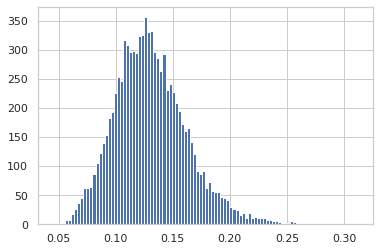

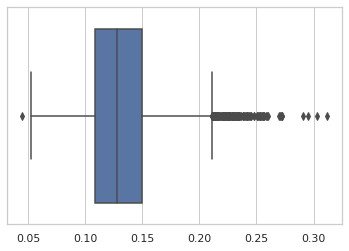

In [17]:
#Gráfica
plt.hist(valoresSD, bins = 100)
plt.show()

ax = sns.boxplot(x=valoresSD)


In [18]:
dfvalSD = pd.DataFrame(valoresSD)
d = dfvalSD.describe().T
d

,count,mean,std,min,25%,50%,75%,max
0,9193.0,0.130729,0.031995,0.04503,0.108483,0.127906,0.149568,0.311587


In [19]:
dfvalSD.columns= ['val']

In [20]:
#Bigotes
riq = (d['75%'].values - d['25%'].values)*1.5
bd  = riq + d['75%'].values
bi  = d['25%'].values - riq

In [21]:
#Posiciones de los outliers
idsSD = ((dfvalSD['val'] > bd[0]) | (dfvalSD['val'] < bi[0]) )

In [22]:
idssSD = dfvalSD[idsSD] #valores
idssSD.index        #indices

Int64Index([   0, 9039, 9040, 9041, 9042, 9043, 9044, 9045, 9046, 9047,
            ...
            9183, 9184, 9185, 9186, 9187, 9188, 9189, 9190, 9191, 9192],
           dtype='int64', length=155)

In [23]:
#Definir outliers
porc = len(idssSD)/len(valoresSD)
lim = int((len(ordenSD)*porc)-1)
print(porc*100,'% ->',lim)

1.6860654846078535 % -> 153


In [24]:
#Índices
idx_outSD =  ordenSD[0:lim]
idx_outSD

idx_inlSD =  ordenSD[lim:len(ordenSD)]
idx_inlSD

print(len(idx_inlSD),'-',len(idx_outSD),'=',len(idx_inlSD)+len(idx_outSD))

9040 - 153 = 9193


### Eliminación de outliers

Excluir el % de outliers en el dataset

In [25]:
#dataset sin dummies con outliers ordenado
dfsdco = dfsd.iloc[ordenSD,:].reset_index()
dfsdco = dfsdco.iloc[:,1:]
dfsdco.head()

,p_12,p_15a,p_15b,p_19a,p_19b,p_19c,p_19d,p_19e,p_20a,p_20b,p_36a,p_36b,p_44,p_45b,p_45c,p_45d,p_45e,p_45f,p_49b,p_49c,p_66b,p_66c,p_66d,p_67b,p_67c,p_68b,p_68c,p_83b,p_83c,p_83d,p_83e,p_83f,p_84b,p_84c,p_84d,p_86a,p_86b,p_86c,p_86d,p_86e,...,p_244_ip,p_43a,p_43b,p_43c,p_43d,p_7,p_10,p_6,p_5,p_146,p_147,p_148,p_158,p_162,p_165,p_171,p_174,p_178,p_184,p_284,p_285,p_286,p_258,p_259,p_260,p_281,p_282,p_283,p_312,p_313,p_314,p_315,p_316,p_317,p_318,p_319,p_320,p_321,p_322,p_323
0,-0.222355,-0.485034,0.142660,-0.462615,-0.551602,1.133656,-0.300566,-0.727225,-0.123561,-0.163986,0.163895,-0.414759,0.973283,0.207810,-0.449842,0.767718,-0.449285,-0.230636,0.231964,-0.558821,0.697157,-0.050646,-0.604419,-0.026493,0.031726,0.132245,-0.074532,-0.166237,0.324370,-0.550445,-0.490273,-0.021703,-0.012921,-0.54657,-0.189975,0.034353,0.138417,-0.182402,-0.498157,-0.130096,...,-0.191718,-0.062534,1.27393,-0.315628,-0.53425,0304,2,3,1,4,10,4,1,1,1,1,1,1,6,14,-88,19,2,4,2,4,4,2,2,3,4,4,4,2,4,4,4,5,4,4
1,-0.838045,-0.485034,-0.743137,-0.462615,-0.551602,0.104476,-0.300566,-0.727225,-0.123561,-1.092043,0.163895,-1.185752,0.995613,0.207810,-0.449842,-0.138887,-0.449285,-0.230636,-0.328747,-0.558821,-1.196958,-0.877638,0.647868,-1.028588,0.031726,-0.920982,-0.074532,-0.166237,-0.779463,-0.550445,1.071137,-0.021703,-0.012921,-0.54657,-0.189975,-0.680450,-0.911865,-0.182402,1.077998,-0.130096,...,-0.202206,-0.062534,1.27393,-0.315628,-0.53425,601,2,6,1,4,10,4,1,1,1,1,1,1,6,14,-88,19,2,4,2,4,4,2,4,4,4,4,4,4,4,4,4,4,4,4
2,-0.838045,-1.398157,0.142660,-0.462615,-0.551602,0.104476,-0.300566,-0.727225,-0.123561,-1.092043,0.163895,-1.185752,1.017943,-0.799924,-0.449842,-0.138887,-0.449285,-0.230636,-0.889457,0.424242,-0.249901,-0.877638,0.021724,-0.026493,-0.669648,0.132245,-0.783690,-0.166237,0.324370,-0.550445,-0.490273,-0.021703,-0.012921,-0.54657,-0.189975,-0.680450,0.138417,-0.182402,-0.498157,-0.130096,...,-0.296600,-0.062534,1.27393,-0.315628,-0.53425,1606,3,16,1,4,10,4,1,1,1,1,1,1,6,14,-88,19,1,-98,2,4,4,2,3,3,3,4,4,4,4,4,4,4,4,4
3,-0.222355,0.428088,-0.743137,-0.462615,-0.551602,0.104476,0.790145,-0.727225,-0.762351,0.764071,0.163895,-0.414759,0.995613,-0.799924,1.335560,0.767718,-0.449285,-0.230636,0.231964,-0.558821,-0.249901,-0.050646,0.021724,-0.026493,0.031726,0.132245,-0.074532,-0.166237,0.324370,-0.550445,-0.490273,-0.021703,-0.012921,-0.54657,-0.189975,0.034353,0.138417,-0.182402,-0.498157,-0.130096,...,-0.474900,-0.062534,1.27393,-0.315628,-0.53425,1014,2,10,1,4,10,4,1,1,1,1,1,1,6,14,-88,19,2,4,3,4,3,2,4,4,4,4,2,3,4,4,4,4,4,4
4,-0.838045,-0.485034,-0.743137,-0.462615,-0.551602,0.104476,-1.391276,0.567349,-0.762351,-0.163986,0.163895,-1.185752,0.995613,-0.799924,-0.449842,-0.138887,-0.449285,-0.230636,-0.889457,0.424242,-0.249901,-0.050646,-0.604419,-0.026493,-0.669648,0.132245,-0.783690,-0.166237,0.324370,-0.550445,-0.490273,-0.021703,-0.012921,-0.54657,-0.189975,-0.680450,0.138417,-0.182402,-0.498157,-0.130096,...,0.025913,-0.062534,1.27393,-0.315628,-0.53425,1609,3,16,1,4,10,4,1,1,1,1,1,1,6,14,-88,19,-98,3,1,4,4,2,4,3,4,4,4,4,4,4,4,4,4,4


In [34]:
dford = pd.DataFrame()
dford = df2[df2['año']==2018]
dford = dford.iloc[ordenSD,:]
dford = dford.drop('encuesta', axis=1)
dford.head()

,Unnamed: 0,año,p_5,p_6,p_7,p_10,p_12,p_15a,p_15b,p_19a,p_19b,p_19c,p_19d,p_19e,p_20a,p_20b,p_36a,p_36b,p_43a,p_43b,p_43c,p_43d,p_44,p_45b,p_45c,p_45d,p_45e,p_45f,p_49b,p_49c,p_66b,p_66c,p_66d,p_67b,p_67c,p_68b,p_68c,p_83b,p_83c,p_83d,...,p_126,p_146,p_147,p_148,p_157,p_158,p_162,p_165,p_171,p_174,p_178,p_184,p_211,p_212,p_213,p_214,p_227,p_258,p_259,p_260,p_281,p_282,p_283,p_284,p_285,p_286,p_312,p_313,p_314,p_315,p_316,p_317,p_318,p_319,p_320,p_321,p_322,p_323,p_244_ip,p_232_gp
1508,1508,2018,1,3,0304,2,3,1,2,0,0,2,1,0,2,1,1,2,0,1,0,0,1,1,0,2,0,0,3,0,2,1,0,1,2,1,2,0,1,0,...,0,4,10,4,5,1,1,1,1,1,1,6,11,0,0,0,375000,2,4,2,4,4,2,14,-88,19,2,3,4,4,4,2,4,4,4,5,4,4,346666.667,391666.667
27374,27374,2018,1,6,601,2,2,1,1,0,0,1,1,0,2,0,1,1,0,1,0,0,2,1,0,1,0,0,2,0,0,0,2,0,2,0,2,0,0,0,...,0,4,10,4,6,1,1,1,1,1,1,6,5,0,0,0,340000,2,4,2,4,4,2,14,-88,19,4,4,4,4,4,4,4,4,4,4,4,4,340000.000,500000.000
24302,24302,2018,1,16,1606,3,2,0,2,0,0,1,1,0,2,0,1,1,0,1,0,0,3,0,0,1,0,0,1,1,1,0,1,1,1,1,1,0,1,0,...,-88,4,10,4,5,1,1,1,1,1,1,6,11,0,0,0,400000,1,-98,2,4,4,2,14,-88,19,3,3,3,4,4,4,4,4,4,4,4,4,280000.000,300000.000
15159,15159,2018,1,10,1014,2,3,2,1,0,0,1,2,0,1,2,1,2,0,1,0,0,2,0,1,2,0,0,3,0,1,1,1,1,2,1,2,0,1,0,...,0,4,10,4,5,1,1,1,1,1,1,6,14,0,0,0,0,2,4,3,4,3,2,14,-88,19,4,4,4,4,2,3,4,4,4,4,4,4,166666.667,133333.333
23678,23678,2018,1,16,1609,3,2,1,1,0,0,1,0,1,1,1,1,1,0,1,0,0,2,0,0,1,0,0,1,1,1,1,0,1,1,1,1,0,1,0,...,0,4,10,4,7,1,1,1,1,1,1,6,11,0,0,0,800000,-98,3,1,4,4,2,14,-88,19,4,3,4,4,4,4,4,4,4,4,4,4,485000.000,500000.000


In [35]:
#dford.to_csv('/content/gdrive/My Drive/calidad_de_vida_medellin/github/Data/Other/dataset-original-ord.csv')

In [ ]:
#guardar sin dummies con outliers
dfsdco.to_csv('/content/gdrive/My Drive/calidad_de_vida_medellin/github/Data/Modeling/T2_ECV_sindum_conout_ord.csv', sep=";")

In [ ]:
#guardar sin dummies sin outliers
#dfsdso = dfsdco
dfsdso = dfsdco.iloc[:len(idx_inlSD),:].reset_index()
dfsdso = dfsdso.iloc[:,1:]

In [ ]:
dfsdso.shape

(9040, 92)

In [ ]:
dfsdso.head()

,p_12,p_15a,p_15b,p_19a,p_19b,p_19c,p_19d,p_19e,p_20a,p_20b,p_36a,p_36b,p_44,p_45b,p_45c,p_45d,p_45e,p_45f,p_49b,p_49c,p_66b,p_66c,p_66d,p_67b,p_67c,p_68b,p_68c,p_83b,p_83c,p_83d,p_83e,p_83f,p_84b,p_84c,p_84d,p_86a,p_86b,p_86c,p_86d,p_86e,...,p_244_ip,p_43a,p_43b,p_43c,p_43d,p_7,p_10,p_6,p_5,p_146,p_147,p_148,p_158,p_162,p_165,p_171,p_174,p_178,p_184,p_284,p_285,p_286,p_258,p_259,p_260,p_281,p_282,p_283,p_312,p_313,p_314,p_315,p_316,p_317,p_318,p_319,p_320,p_321,p_322,p_323
0,-0.222355,-0.485034,0.142660,-0.462615,-0.551602,1.133656,-0.300566,-0.727225,-0.123561,-0.163986,0.163895,-0.414759,0.973283,0.207810,-0.449842,0.767718,-0.449285,-0.230636,0.231964,-0.558821,0.697157,-0.050646,-0.604419,-0.026493,0.031726,0.132245,-0.074532,-0.166237,0.324370,-0.550445,-0.490273,-0.021703,-0.012921,-0.54657,-0.189975,0.034353,0.138417,-0.182402,-0.498157,-0.130096,...,-0.191718,-0.062534,1.27393,-0.315628,-0.53425,0304,2,3,1,4,10,4,1,1,1,1,1,1,6,14,-88,19,2,4,2,4,4,2,2,3,4,4,4,2,4,4,4,5,4,4
1,-0.838045,-0.485034,-0.743137,-0.462615,-0.551602,0.104476,-0.300566,-0.727225,-0.123561,-1.092043,0.163895,-1.185752,0.995613,0.207810,-0.449842,-0.138887,-0.449285,-0.230636,-0.328747,-0.558821,-1.196958,-0.877638,0.647868,-1.028588,0.031726,-0.920982,-0.074532,-0.166237,-0.779463,-0.550445,1.071137,-0.021703,-0.012921,-0.54657,-0.189975,-0.680450,-0.911865,-0.182402,1.077998,-0.130096,...,-0.202206,-0.062534,1.27393,-0.315628,-0.53425,601,2,6,1,4,10,4,1,1,1,1,1,1,6,14,-88,19,2,4,2,4,4,2,4,4,4,4,4,4,4,4,4,4,4,4
2,-0.838045,-1.398157,0.142660,-0.462615,-0.551602,0.104476,-0.300566,-0.727225,-0.123561,-1.092043,0.163895,-1.185752,1.017943,-0.799924,-0.449842,-0.138887,-0.449285,-0.230636,-0.889457,0.424242,-0.249901,-0.877638,0.021724,-0.026493,-0.669648,0.132245,-0.783690,-0.166237,0.324370,-0.550445,-0.490273,-0.021703,-0.012921,-0.54657,-0.189975,-0.680450,0.138417,-0.182402,-0.498157,-0.130096,...,-0.296600,-0.062534,1.27393,-0.315628,-0.53425,1606,3,16,1,4,10,4,1,1,1,1,1,1,6,14,-88,19,1,-98,2,4,4,2,3,3,3,4,4,4,4,4,4,4,4,4
3,-0.222355,0.428088,-0.743137,-0.462615,-0.551602,0.104476,0.790145,-0.727225,-0.762351,0.764071,0.163895,-0.414759,0.995613,-0.799924,1.335560,0.767718,-0.449285,-0.230636,0.231964,-0.558821,-0.249901,-0.050646,0.021724,-0.026493,0.031726,0.132245,-0.074532,-0.166237,0.324370,-0.550445,-0.490273,-0.021703,-0.012921,-0.54657,-0.189975,0.034353,0.138417,-0.182402,-0.498157,-0.130096,...,-0.474900,-0.062534,1.27393,-0.315628,-0.53425,1014,2,10,1,4,10,4,1,1,1,1,1,1,6,14,-88,19,2,4,3,4,3,2,4,4,4,4,2,3,4,4,4,4,4,4
4,-0.838045,-0.485034,-0.743137,-0.462615,-0.551602,0.104476,-1.391276,0.567349,-0.762351,-0.163986,0.163895,-1.185752,0.995613,-0.799924,-0.449842,-0.138887,-0.449285,-0.230636,-0.889457,0.424242,-0.249901,-0.050646,-0.604419,-0.026493,-0.669648,0.132245,-0.783690,-0.166237,0.324370,-0.550445,-0.490273,-0.021703,-0.012921,-0.54657,-0.189975,-0.680450,0.138417,-0.182402,-0.498157,-0.130096,...,0.025913,-0.062534,1.27393,-0.315628,-0.53425,1609,3,16,1,4,10,4,1,1,1,1,1,1,6,14,-88,19,-98,3,1,4,4,2,4,3,4,4,4,4,4,4,4,4,4,4


In [ ]:
dfsdso.to_csv('/content/gdrive/My Drive/calidad_de_vida_medellin/github/Data/Modeling/T2_ECV_sindum_sinout_ord.csv', sep=";")

Calcular matriz de Gower para el ds con outliers

In [ ]:
#Adicionar el vector en la útima posición
dfsdso = dfsdso.append(vecCentroSD, ignore_index=True)
dfsdso.tail()

,p_12,p_15a,p_15b,p_19a,p_19b,p_19c,p_19d,p_19e,p_20a,p_20b,p_36a,p_36b,p_44,p_45b,p_45c,p_45d,p_45e,p_45f,p_49b,p_49c,p_66b,p_66c,p_66d,p_67b,p_67c,p_68b,p_68c,p_83b,p_83c,p_83d,p_83e,p_83f,p_84b,p_84c,p_84d,p_86a,p_86b,p_86c,p_86d,p_86e,...,p_244_ip,p_43a,p_43b,p_43c,p_43d,p_7,p_10,p_6,p_5,p_146,p_147,p_148,p_158,p_162,p_165,p_171,p_174,p_178,p_184,p_284,p_285,p_286,p_258,p_259,p_260,p_281,p_282,p_283,p_312,p_313,p_314,p_315,p_316,p_317,p_318,p_319,p_320,p_321,p_322,p_323
9036,2.240405,2.254333,1.028458,3.134099,-0.551602,4.221195,-1.391276,-0.727225,0.515228,2.620185,3.093632,0.356234,0.995613,-0.799924,-0.449842,3.487534,-0.449285,-0.230636,2.474808,-0.558821,-0.249901,0.776345,1.900155,-0.026493,1.434473,0.132245,1.343784,-0.166237,0.324370,0.975854,2.632547,-0.021703,1.958192,0.942222,-0.189975,0.749156,0.138417,-0.182402,4.230308,-0.130096,...,-0.501120,-0.062534,1.273930,-0.315628,3.170967,0511,3,5,1,5,10,4,1,1,1,2,1,1,6,1,7,4,2,2,2,4,4,2,3,2,3,3,3,1,2,1,1,4,4,3
9037,2.856095,2.254333,1.914255,1.335742,2.374030,2.162836,0.790145,-0.727225,2.431596,0.764071,1.140474,2.669212,0.995613,2.223277,1.335560,-0.138887,-0.449285,-0.230636,2.474808,-0.558821,0.697157,4.084311,-0.604419,0.975601,1.434473,1.185471,1.343784,-0.166237,1.428203,-0.550445,-0.490273,-0.021703,-0.998477,2.431014,-0.189975,2.893564,1.188700,-0.182402,-0.498157,-0.130096,...,-0.531405,-0.062534,-0.437203,-0.315628,1.935895,816,1,8,1,5,10,3,1,1,2,2,1,1,4,14,-88,19,3,3,2,4,5,2,2,2,2,2,2,4,5,2,2,2,2,3
9038,-0.838045,-0.485034,-0.743137,-0.462615,-0.551602,0.104476,-0.300566,-0.727225,-1.401140,0.764071,-0.812684,-0.414759,-1.014063,0.207810,1.335560,-1.045492,-0.449285,-0.230636,-0.328747,-0.558821,0.697157,-0.877638,-0.604419,-0.026493,-0.669648,-0.920982,-0.074532,-0.166237,0.324370,-0.550445,1.071137,-0.021703,-0.012921,-0.546570,3.611177,-1.395253,0.138417,-0.182402,-0.498157,-0.130096,...,-0.328065,-0.062534,-0.437203,-0.315628,-0.534250,722,1,7,1,5,11,4,1,1,1,2,1,2,6,1,11,10,-98,3,2,2,1,3,2,2,3,3,2,5,2,2,3,3,3,4
9039,3.471785,2.254333,2.800053,1.335742,2.374030,2.162836,0.790145,0.567349,3.070385,0.764071,0.163895,4.211198,0.973283,4.238745,-0.449842,-1.045492,-0.449285,-0.230636,-0.328747,-0.558821,1.644214,-0.050646,2.526298,1.977696,1.434473,2.238698,1.343784,-0.166237,1.428203,0.975854,-0.490273,-0.021703,0.972636,0.942222,-0.189975,2.893564,2.238983,-0.182402,-0.498157,-0.130096,...,-0.626630,-0.062534,-0.437203,-0.315628,0.700823,405,2,4,1,4,8,4,1,1,1,1,1,2,6,1,7,19,1,4,3,2,2,3,2,2,2,2,2,4,2,2,2,2,3,3
9040,-0.222355,-0.485034,0.142660,-0.462615,-0.551602,0.104476,-0.300566,-0.727225,-0.123561,0.764071,0.163895,-0.414759,0.973283,-0.799924,-0.449842,-0.138887,-0.449285,-0.230636,-0.328747,-0.558821,-0.249901,-0.050646,-0.604419,-0.026493,0.031726,0.132245,-0.074532,-0.166237,-0.779463,-0.550445,-0.490273,-0.021703,-0.012921,-0.546570,-0.189975,0.034353,0.138417,-0.182402,-0.498157,-0.130096,...,-0.246781,-0.062534,-0.437203,-0.315628,-0.534250,9019,2,16,1,4,10,4,1,1,1,1,1,1,6,14,-88,19,1,4,2,4,4,2,3,3,4,4,4,4,4,4,4,4,4,4


In [ ]:
#Gower
start_time = time.time()
dm = gower.gower_matrix(dfsdso)
print("--- %s minutess ---" % ((time.time() - start_time)/60))

--- 12.944858316580454 minutess ---


In [ ]:
# Matriz de distancia sin dummies
dfG = pd.DataFrame(dm)
dfG.to_csv("/content/gdrive/My Drive/calidad_de_vida_medellin/github/Data/Other/matDis_sindum_sinout_ord.csv",sep=";")